# At Prediction_1 file the non-uniformity coefs map were under research. The following was made
## Basic EDA
## Multioutput prediction for different models
## Different learning approaches were tested among which are:
### Random cell fit where cells were chosen randomly to observe effects on accuracy + chained features collection were considered
### Random cell fit based on graphs where each cell has edges with other cell + chained features collection were considered
### Ordered cell fit when cells were passed it a default order + chained features collection were considered

## As experiments reports the hightes accuracy can be achieved by using Ridge model
## Different training techniques reports almost the same MAE on test dataset but for certain cells there are significant differences

# Highest accuracy is reached by using sklearn in-built Stacking method


In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join('..'))) # imports top level

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import display
import scipy
from collections import defaultdict

In [3]:
df = pd.read_excel("input.xlsx", sheet_name="no_burnup")

In [4]:
d = display.Display(df=df)
d.quick_processing()

The columns with prefix  are not in DataFrame


In [5]:
d.CORE_PARTS.keys()

dict_keys(['default', 'coef', 'left', 'percentage', 'burnup', 'fuel_type'])

In [6]:
percentage_cols =  d.CORE_PARTS["percentage"]["ALL_CELLS"]
fuel_left_cols = d.CORE_PARTS["left"]["ALL_CELLS"]

In [7]:
d.df

,Name,pmar,"p, %","p, beff",7-6_s,7-5_s,7-4_s,7-3_s,6-6_s,6-5_s,...,average_t,right_center_side_t,left_center_side_t,right_side_t,left_side_t,center_t,qul_t,qur_t,qll_t,qlr_t
0,112,1.07861,7.297184,9.295775,1.051558,0.790403,1.013165,1.037370,0.912569,1.189814,...,282.50,282.5,282.5,286.0,279.0,282.5,279.0,279.0,286.0,286.0
1,114,1.08357,7.774369,9.903655,0.648665,0.664725,1.083983,0.954085,0.795975,0.990852,...,282.50,286.0,279.0,286.0,272.0,286.0,279.0,286.0,279.0,286.0
2,114_7-6,1.07174,6.755688,8.605972,1.114553,0.746294,1.187454,1.001877,0.900434,1.090843,...,282.50,286.0,279.0,286.0,272.0,286.0,279.0,286.0,279.0,286.0
3,114_fake11,1.08923,8.368326,10.660287,0.641218,0.642833,1.041846,0.908672,0.806680,0.976815,...,282.50,286.0,279.0,286.0,272.0,286.0,279.0,286.0,279.0,286.0
4,114_fake12,1.10397,9.594128,12.221820,0.676469,1.019903,1.181528,0.942797,0.843354,0.994229,...,282.50,286.0,279.0,286.0,272.0,286.0,279.0,286.0,279.0,286.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,127_fake6,1.07530,7.108597,9.055537,1.010889,1.128600,1.227110,0.918639,0.939258,0.789988,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
178,127_fake_burn1,1.09458,8.861057,11.287971,0.876408,0.813834,0.791522,1.203869,0.830220,0.744404,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
179,127_fake_burn2,1.10140,9.426764,12.008617,0.613199,0.797287,1.088565,1.222016,0.800700,0.732128,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0
180,127_fake_burn1_e1,1.03500,3.601943,4.588462,0.897885,0.823120,0.784481,1.199148,0.847024,0.735022,...,284.25,286.0,282.5,286.0,279.0,286.0,279.0,286.0,286.0,286.0


In [8]:
df = d.df

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, Normalizer, PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, KFold, ShuffleSplit

from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge, RidgeCV, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    r2_score, 
    PredictionErrorDisplay
)

from sklearn.base import clone
from collections import Counter

In [10]:
df1 = df.loc[:,
    [
        *d.CORE_PARTS["burnup"]["ALL_CELLS"],
        *d.CORE_PARTS["coef"]["ALL_CELLS"],
        # *percentage_cols,
        *fuel_left_cols,
        # "average_p",
        # "left_side",
        # "center",
        # "right_side",
        # "qur",
        # "qul",
        # "qll",
        # "qlr",
        # "left_side_s",
        # "center_s",
        # "right_side_s",
        # "average",
        # "p, %"
    ]
]

In [11]:
# df_valid = df1.sample(frac=0.1)
# df1 = df1.drop(index=df_valid.index)

In [12]:
df1

,7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,6-4_b,6-3_b,5-6_b,5-3_b,...,4-6_l,4-3_l,3-6_l,3-5_l,3-4_l,3-3_l,2-6_l,2-5_l,2-4_l,2-3_l
0,0.00,144.21,71.7355,80.52,75.7900,63.7855,155.7140,19.4510,108.0405,45.99,...,212.79,195.27,196.0205,120.2835,196.1795,247.0330,155.460,289.17,116.04,201.93
1,147.06,171.99,42.8400,118.23,101.3095,99.8255,30.6075,58.8565,135.5475,98.37,...,177.36,300.00,170.6335,238.1820,161.2790,211.1785,165.254,250.74,130.35,171.60
2,0.00,171.99,42.8400,118.23,101.3095,99.8255,30.6075,58.8565,135.5475,98.37,...,177.36,152.94,170.6335,238.1820,161.2790,211.1785,165.254,250.74,130.35,171.60
3,148.35,173.34,45.0000,120.15,102.5815,101.6275,32.8865,60.8970,136.9520,101.16,...,300.00,296.49,169.3350,236.0885,159.3975,209.1910,163.982,248.79,128.94,169.89
4,148.35,45.00,0.0000,120.15,102.5815,101.6275,32.8865,60.8970,136.9520,101.16,...,300.00,296.49,169.3350,236.0885,159.3975,209.1910,163.982,128.94,248.79,169.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,39.69,28.74,0.0000,124.23,87.9800,154.8130,69.8805,86.3900,108.6500,149.04,...,179.16,157.32,178.9545,201.5590,111.3795,182.3995,260.790,176.97,300.00,271.38
178,39.69,124.23,149.0400,28.74,87.9800,154.8130,69.8805,86.3900,108.6500,0.00,...,179.16,300.00,178.9545,201.5590,111.3795,182.3995,260.790,176.97,157.32,271.38
179,149.04,124.23,39.6900,28.74,87.9800,154.8130,86.3900,69.8805,108.6500,0.00,...,179.16,300.00,178.9545,182.3995,111.3795,201.5590,157.320,176.97,260.79,271.38
180,52.26,135.69,160.0200,45.66,98.3945,163.8495,84.9590,100.3290,119.3295,23.22,...,166.98,277.38,168.6460,188.0970,101.7070,168.7520,248.040,165.87,146.34,255.48


In [13]:
y1 = df1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"][0]]
X_raw1 = df1.drop(
    d.CORE_PARTS["coef"]["ALL_CELLS"],
    axis=1
)

In [14]:
ct_c_test = ColumnTransformer(
    [
        # ("row1", Normalizer(), X_raw1.columns[:20]),
        # ("row2", Normalizer(), X_raw1.columns[20:]),
        
        ("row11", Normalizer(), X_raw1.columns[:4]),
        ("row12", Normalizer(), X_raw1.columns[4:8]),
        ("row13", Normalizer(), X_raw1.columns[8:12]),
        ("row14", Normalizer(), X_raw1.columns[12:16]),
        ("row15", Normalizer(), X_raw1.columns[16:20]),

        ("row21", Normalizer(), X_raw1.columns[20:24]),
        ("row22", Normalizer(), X_raw1.columns[24:28]),
        ("row23", Normalizer(), X_raw1.columns[28:32]),
        ("row24", Normalizer(), X_raw1.columns[32:36]),
        ("row25", Normalizer(), X_raw1.columns[36:40]),
    ]
).set_output(transform="pandas")

In [15]:
X1_test = ct_c_test.fit_transform(X_raw1)

In [16]:
X_traint1, X_testt1, y_traint1, y_testt1 = train_test_split(X1_test, y1, random_state=42, test_size=0.2)

In [17]:
ridget1 = Ridge().fit(X_traint1, y_traint1)

In [18]:
y_pred_ridget1 = ridget1.predict(X_testt1)

In [19]:
mean_absolute_error(
    y_pred_ridget1,
    y_testt1
)

0.056958347925955444

In [20]:
ct_c = ColumnTransformer(
    [
        ("", StandardScaler(), X_raw1.columns)
    ],
    remainder="drop"
).set_output(transform="pandas")

In [21]:
X1 = ct_c.fit_transform(X_raw1)

In [22]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42, test_size=0.2)

In [23]:
cross_val_score(Ridge(), X1, y1, cv=3, scoring="neg_mean_absolute_error")

array([-0.02679869, -0.02600365, -0.02929153])

In [24]:
ridge1 = Ridge().fit(X_train1, y_train1)

In [25]:
y_pred_ridge1 = ridge1.predict(X_test1)

Text(0.5, 1.0, 'Just quick view on Predictive power of Ridge')

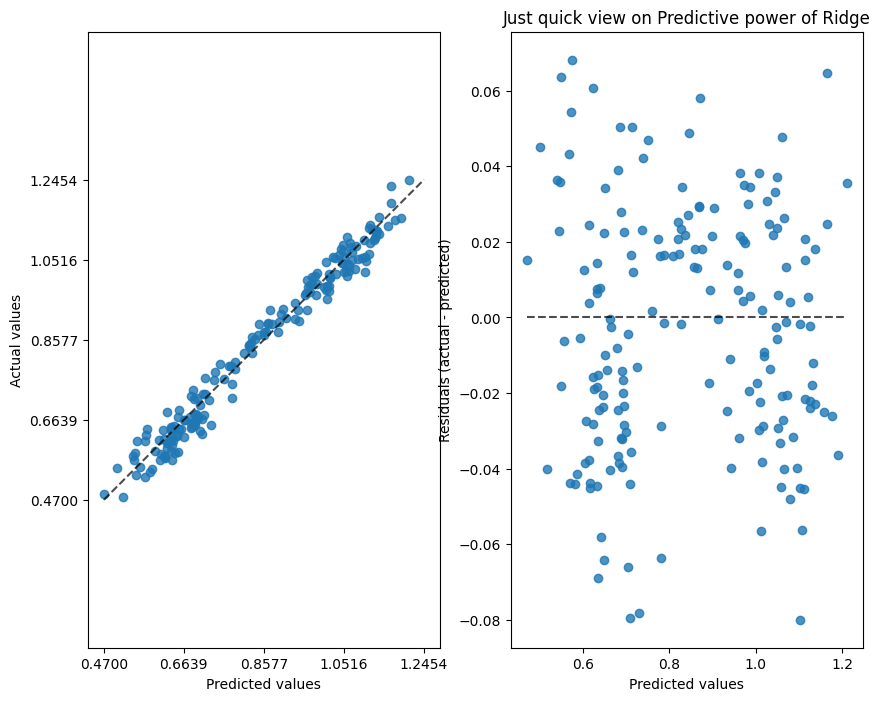

In [26]:
fig, axs = plt.subplots(1,2, figsize=(10,8))
PredictionErrorDisplay.from_predictions(
    y1,
    y_pred=cross_val_predict(Ridge(), X1, y1, cv=3),
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=42,
)
PredictionErrorDisplay.from_predictions(
    y1,
    y_pred=cross_val_predict(Ridge(), X1, y1, cv=3),
    kind="residual_vs_predicted",
    ax=axs[1],
    random_state=42,
)
plt.title("Just quick view on Predictive power of Ridge")


In [27]:
y_pred_ridge1

array([1.04110391, 0.66211903, 0.77055729, 1.0668849 , 0.61622432,
       0.63922988, 0.61876396, 0.83270521, 1.1462882 , 1.05684152,
       0.75084691, 1.01441072, 0.85551633, 0.81914264, 0.65946939,
       0.62968138, 0.75586224, 1.12549431, 1.04485349, 0.67768051,
       0.97831277, 0.95336856, 0.71970937, 1.12887642, 0.66485079,
       1.04905063, 0.9036889 , 0.64399557, 1.0187998 , 0.73625511,
       1.03789334, 0.6957762 , 0.91008928, 0.81109272, 0.90290094,
       1.11153616, 0.50477768])

In [28]:
mean_absolute_error(
    y_pred_ridge1,
    y_test1
)

0.019054424984318176

In [29]:
y_mo = df1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]

# rch_order = [ 4,  5,  6,  7,  1,  3,  8,  9,  0, 10,  2, 11, 19, 18, 14, 12, 17,
#         16, 15, 13]

# rch_order =  [
#     '7-6_s',
#     '7-5_s',
#     '6-6_s',
#     '6-5_s',
#     '7-4_s',
#     '7-3_s',
#     '6-4_s',
#     '6-3_s',
#     '5-3_s',
#     '4-3_s',
#     '3-3_s',
#     '3-4_s',
#     '2-3_s',
#     '2-4_s',
#     '2-5_s',
#     '2-6_s',
#     '3-5_s',
#     '3-6_s',
#     '4-6_s',
#     '5-6_s'
# ]
# # y_mo = y_mo.reindex(columns=y_mo.columns[rch_order])
# y_mo = y_mo.reindex(columns=rch_order)

X_mo_raw = df1.drop(
    d.CORE_PARTS["coef"]["ALL_CELLS"],
    axis=1
)

In [30]:
y_mo.columns

Index(['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-6_s', '6-5_s', '6-4_s', '6-3_s',
       '5-6_s', '5-3_s', '4-6_s', '4-3_s', '3-6_s', '3-5_s', '3-4_s', '3-3_s',
       '2-6_s', '2-5_s', '2-4_s', '2-3_s'],
      dtype='object')

In [31]:
ct_mo = ColumnTransformer(
    [
        ("", StandardScaler(), X_mo_raw.columns)
    ],
    remainder="passthrough"
).set_output(transform="pandas")

In [32]:
X_mo = ct_mo.fit_transform( X_mo_raw)

In [94]:
X_train_mo, X_test_mo, y_train_mo, y_test_mo = train_test_split(X_mo, y_mo, random_state=50, test_size=0.2)

## Trying in-built Regressor Chain

In [95]:

mo_ridge = MultiOutputRegressor(Ridge(random_state=42)).fit(X_train_mo, y_train_mo)
rch_ridge = RegressorChain(
    Ridge(random_state=42), 
    random_state=42, 
).fit(X_train_mo, y_train_mo)

In [96]:
mo_ridge_cells = defaultdict(list)
rch_ridge_cells = defaultdict(list)

for i in range(y_mo.shape[1]):
    test_array = X_test_mo.to_numpy()
    y_step = y_test_mo[y_test_mo.columns[i]]
    print("Predictable :", y_test_mo.columns[i])
    print(mo_ridge.estimators_[i].score(X_test_mo, y_step), end=" ")
    print(rch_ridge.estimators_[i].score(pd.concat([X_test_mo, y_test_mo[y_test_mo.columns[:i]]], axis=1), y_step))
    # print(mo_ridge.estimators_[i].coef_, end=" ")
    

    mo_mea = mean_absolute_error(
            mo_ridge.estimators_[i].predict(X_test_mo),
            y_step
        )

    mo_ridge_cells[y_test_mo.columns[i]].append(
        mo_mea
    )
    print(
        "MAE:", mo_mea
    )

    rch_mea = mean_absolute_error(
        rch_ridge.estimators_[i].predict(pd.concat([X_test_mo, y_test_mo[y_test_mo.columns[:i]]], axis=1)),
        y_step    
    )
    
    rch_ridge_cells[y_test_mo.columns[i]].append(
        rch_mea
    )
    print(
        "MAE:", rch_mea
    )

Predictable : 7-6_s
0.9863607574812417 0.9863607574812417
MAE: 0.018494945688399794
MAE: 0.018494945688399794
Predictable : 7-5_s
0.9725677133984475 0.973256807560014
MAE: 0.017495175730054727
MAE: 0.017302332588441223
Predictable : 7-4_s
0.9738590336555775 0.9746585642238559
MAE: 0.018341099395718524
MAE: 0.018017087817381084
Predictable : 7-3_s
0.9898459967592786 0.9898272076204482
MAE: 0.013542679675520603
MAE: 0.013562784580932708
Predictable : 6-6_s
0.9904015093294145 0.9906262529959815
MAE: 0.013944628217332394
MAE: 0.013867436615381496
Predictable : 6-5_s
0.9848456578242136 0.9852804033642543
MAE: 0.017730623695056947
MAE: 0.017514508439428624
Predictable : 6-4_s
0.9895560799587275 0.9898805246483577
MAE: 0.013480506394756907
MAE: 0.013231913071958602
Predictable : 6-3_s
0.9895228249792842 0.9901013580457184
MAE: 0.013407671220928686
MAE: 0.013084417178433356
Predictable : 5-6_s
0.9906866228373038 0.9912505029975454
MAE: 0.013219499902142743
MAE: 0.012811250262707205
Predictable

/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but Ridge was fitted without feature names
  

In [97]:
mo_ridge_cells, rch_ridge_cells

(defaultdict(list,
             {'7-6_s': [0.018494945688399794],
              '7-5_s': [0.017495175730054727],
              '7-4_s': [0.018341099395718524],
              '7-3_s': [0.013542679675520603],
              '6-6_s': [0.013944628217332394],
              '6-5_s': [0.017730623695056947],
              '6-4_s': [0.013480506394756907],
              '6-3_s': [0.013407671220928686],
              '5-6_s': [0.013219499902142743],
              '5-3_s': [0.01700865376682318],
              '4-6_s': [0.03765741986971743],
              '4-3_s': [0.01803569146360066],
              '3-6_s': [0.011388374008464536],
              '3-5_s': [0.010037081142550473],
              '3-4_s': [0.018640610705354554],
              '3-3_s': [0.014845168508497703],
              '2-6_s': [0.015067927060389643],
              '2-5_s': [0.014746569297501778],
              '2-4_s': [0.013176560327392155],
              '2-3_s': [0.02329626944595765]}),
 defaultdict(list,
             {'7-6_s': [

In [98]:
y_pred_mo = mo_ridge.predict(X_test_mo)
y_pred_rch = rch_ridge.predict(X_test_mo)

In [99]:
mean_absolute_error(
    y_pred_mo,
    y_test_mo
), mean_absolute_error(
    y_pred_rch,
    y_test_mo
)

(0.016677857775808054, 0.01667785777580806)

### Some piece of statistical stuff on RCH predictions 

Text(0.5, 1.0, 'Just quick view on Predictive power of Regression chain with Ridge')

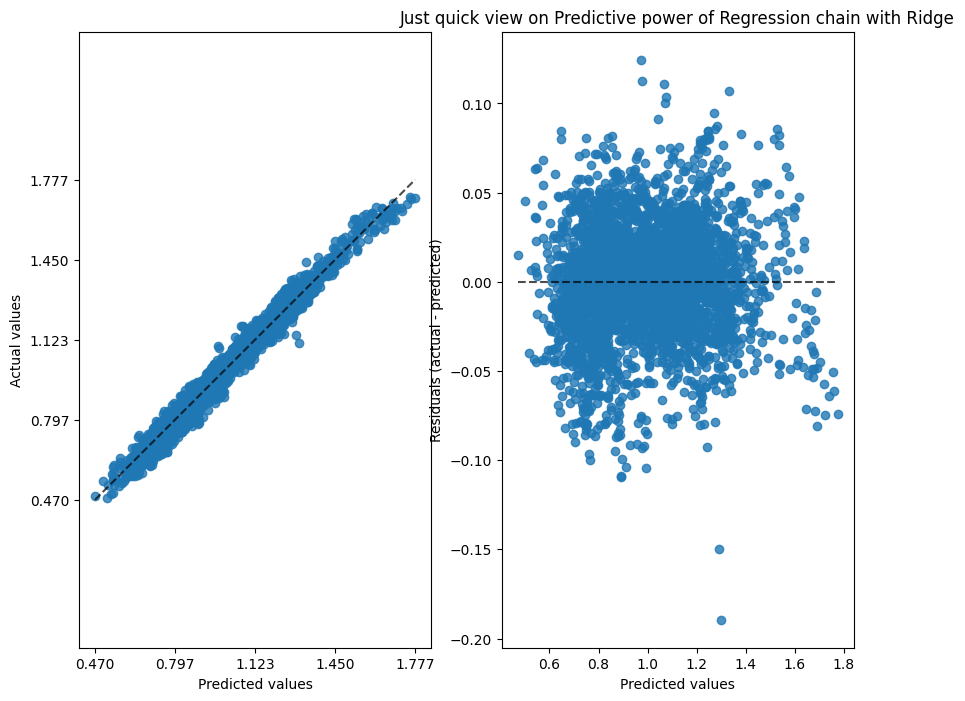

In [100]:
fig, axs = plt.subplots(1,2, figsize=(10,8))
PredictionErrorDisplay.from_predictions(
    y_mo,
    y_pred=cross_val_predict(RegressorChain(Ridge()), X_mo, y_mo, cv=3),
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=42,
)
PredictionErrorDisplay.from_predictions(
    y_mo,
    y_pred=cross_val_predict(RegressorChain(Ridge()), X_mo, y_mo, cv=3),
    kind="residual_vs_predicted",
    ax=axs[1],
    random_state=42,
)
plt.title("Just quick view on Predictive power of Regression chain with Ridge")


In [101]:
#average interval of prediction
rch_mo_intervals = ( ( ( ((y_pred_rch - y_test_mo)**2).sum() / ( len(y_test_mo) - 2) )**(1/2) )  * 1.96 ).to_numpy()
rch_mo_intervals, rch_mo_intervals.mean() 

(array([0.05051385, 0.05206479, 0.05188306, 0.03326164, 0.03696737,
        0.04512432, 0.03704635, 0.03952416, 0.03708421, 0.04281325,
        0.09630698, 0.04578529, 0.0326853 , 0.02575442, 0.04778509,
        0.04332198, 0.03819427, 0.03878246, 0.03414564, 0.05689585]),
 0.0442970142106472)

<Axes: xlabel='20', ylabel='20'>

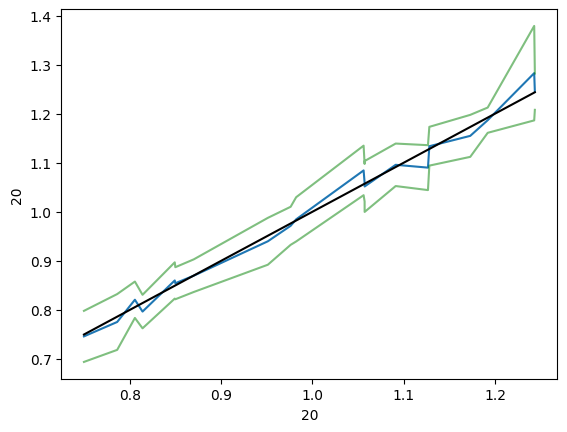

In [102]:
fig, ax = plt.subplots()

rch_mo_int_lower = y_pred_rch - rch_mo_intervals
rch_mo_int_upper = y_pred_rch + rch_mo_intervals

sns.lineplot(x=y_test_mo.iloc[0], y=y_pred_rch[0, :], ax=ax)
sns.lineplot(x=y_test_mo.iloc[0], y=y_test_mo.iloc[0], ax=ax, color="black")
sns.lineplot(x=y_test_mo.iloc[0], y=rch_mo_int_lower[0, :], ax=ax, color="green", alpha=0.5) 
sns.lineplot(x=y_test_mo.iloc[0], y=rch_mo_int_upper[0, :], ax=ax, color="green", alpha=0.5)

# ax.fill_between(y_test_mo["7-6_s"], rch_mo_int_lower, rch_mo_int_upper, alpha=0.2)


In [103]:
d.display(y_test_mo.iloc[0].to_numpy(), dt="_s")

,6,5,4,3
7,1.055993,0.749614,1.057123,0.869911
6,0.849099,0.982099,1.243610,1.128011
5,0.805433,nan,nan,1.172830
4,1.242897,nan,nan,1.126511
3,0.849710,1.191957,0.951068,1.091135
2,1.057093,0.976076,0.813808,0.786022


In [104]:
d.display(y_pred_rch[0], dt="_s")

,6,5,4,3
7,1.084220,0.745818,1.051494,0.869607
6,0.859856,0.984480,1.244836,1.133537
5,0.820513,nan,nan,1.154702
4,1.282568,nan,nan,1.089917
3,0.854186,1.186665,0.939702,1.095694
2,1.059248,0.971315,0.796432,0.775210


# Lets try to do some ensembles like moves

In [33]:
df1 = df.loc[:,
    [
        *d.CORE_PARTS["burnup"]["ALL_CELLS"],
        *d.CORE_PARTS["coef"]["ALL_CELLS"],
        *fuel_left_cols,
    ]
]

In [34]:
m1 = ("gbr", GradientBoostingRegressor(n_estimators=100), True)
m2 = ("bridge", BayesianRidge(), True)
m3 = ("exr", ExtraTreeRegressor(), True)
m4 = ("rfr", RandomForestRegressor(n_estimators=100), True)
# m4 = ("ridge", Ridge(), False)
mm = RidgeCV()
# mm=SVR()

bms = [
    m1, 
    m2,
    m3,
    m4
]

## Stacking + Bagging on trees

In [35]:
def straight_stacking_bagging(
    features,
    df_,
    estimators: list,
    meta_estimator: object,
    bagging: bool = False,
    iter_times: int = 1
):
    
    scores_storage = defaultdict(list)
    errors_storage = defaultdict(list)
    results = []
    order_storage = []
    val_inds = []

    models = {}
    for it in range(iter_times):
        selected_keys = []
        key_features = features.copy()

        df_c = df_.copy()

        
        cv = list(ShuffleSplit(n_splits=len(estimators), test_size=0.2, random_state=np.random.randint(0,100)).split(df_c, df_c))

        models[it] = {}
        
        for n, i in enumerate(features):
            step_sel = i

            models[it][step_sel] = dict()
            
            y = df_c.loc[:, step_sel]
            
            X_raw = df_c.drop(
                key_features,
                axis=1
            )
        
            # print("predicts:", step_sel, "to_predict:", X_raw.columns)
            
            selected_keys.append(step_sel)

            # print("selected:\n", selected_keys, "\n", "left:\n", key_features)
             
            ct = ColumnTransformer(
                [
                    ("", StandardScaler(), X_raw.columns)
                ]
            ).set_output(transform="pandas")
            
            X = ct.fit_transform(X_raw)
            X_base = X.copy()
            
            # do folding
            

            
            models[it][step_sel]["base"] = dict()
            models[it][step_sel]["base"]["ct_base"] = ct
            models[it][step_sel]["base"]["models"] = {}
            models[it][step_sel]["base"]["models"]["bagging"] = defaultdict(list)
            
            # if bagging is True does bootstrapping on all cvs
            
            estimators_names = []
            for n, m in enumerate(estimators):
                
                
                estimators_names.append(m[0])
                # makes new feature
                
                tr, te = cv[n]
                
                # all_train_ind.append(tr)

                if m[2]:
                    bagged = []
                    
                    all_train_ind = []
                    for train, test in cv:
                        
                        model = clone(m[1])
                        model.fit(X.loc[train, :], y.loc[train])
                        print(f"{m[0]}_bagging_train", model.score(X.loc[train, :], y.loc[train]))
                        print(f"{m[0]}_bagging_test", model.score(X.loc[test, :], y.loc[test]))
                        
                        models[it][step_sel]["base"]["models"]["bagging"][f"{m[0]}_bagging"].append(model)

                        # all_ind = [*train, *test]
                        # all_ind.sort()
                        # bagged.append(model.predict(X.loc[all_ind, :]))

                        # train + some test indices
                        test_portion = np.random.choice(test, int(len(test)*0.8), replace=False)
                        # print(test_portion)
                        train_test = [*train, *test_portion]
                        # train_test = [*train]
                        bagged.append(model.predict(X.loc[train_test, :]))
                            
                        all_train_ind.append(train_test)
                    
                    bagged = np.asarray(bagged)
                    # print(bagged.shape)
                    if bagging: #! cannot be used yet
                        X_base[m[0]] = np.full((len(X_base),), np.nan)
                        print(bagged)
                        bagged = bagged.mean(axis=0)
                        
                        X_base.loc[:, m[0]] = bagged
                    else:
                        cols = [f"{m[0]}_bagging_{i}" for i in range(len(cv))]
                        for n, i in enumerate(cols):
                            X_base.loc[
                                all_train_ind[n], 
                                i
                            ] = bagged[n]
                        
                    continue
                X_base[m[0]] = np.full((len(X_base),), np.nan)
                
                model = clone(m[1])
                model.fit(X.loc[tr, :], y.loc[tr])
                
                # print(m[0], model.score(X.loc[te, :], y.loc[te]))

                models[it][step_sel]["base"]["models"][m[0]] = model

                # all_ind = [*tr, *te]
                # all_ind.sort()
                # X_base.loc[:, m[0]] = model.predict(X.loc[all_ind, :])

                # train + some test indices
        
                test_portion = np.random.choice(te, int(len(te)*0.8), replace=False)
                # print(test_portion)
                train_test = [*tr, *test_portion]
                # train_test = [*tr]
                X_base.loc[train_test, m[0]] = model.predict(X.loc[train_test, :])

                

            val_ind = list(set(X_base.index).difference(set(X_base.dropna(axis=0).index)) )
            print("Ind of rows that are not involved in model fitting:", val_ind)
            
            X_base = X_base.dropna(axis=0)
            y = y.loc[X_base.index]
            print(X_base.iloc[:10], y.iloc[:10])
            
            # leaving base features only 
            # X_base = X_base.loc[
            #     :,
            #     list(set(X_base).difference(set(X)))
            # ]
            print(X_base)
            X_base = X_base.reindex(sorted(X_base), axis=1)
            # print(X_base.columns)
            
            # X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(X_base, y, test_size=0.05, random_state=42)
            X_meta_train, y_meta_train = X_base, y

            # adds inds that are in test part
            
            model_meta = clone(meta_estimator)
            model_meta.fit(X_meta_train, y_meta_train)

            models[it][step_sel]["meta"] = model_meta
            
            # y_pred = model_meta.predict(X_meta_test)
            
            # scores_storage[step_sel].append(
            #     model_meta.score(X_meta_test, y_meta_test)    
            # )
            
            # errors_storage[step_sel].append(
            #     mean_absolute_error(
            #         y_meta_test.to_numpy(),
            #         y_pred
            #     )
            # )
            
        order_storage.append(selected_keys)
    
        val_inds.append(val_ind)
    # val_inds = np.array(val_inds).reshape(-1)
    return models, val_inds, order_storage
    # return errors_storage, scores_storage, models, val_inds, order_storage
        

In [36]:
# errors_storage_str_stck_bag,  scores_storage_str_stck_bag, models_str_stck_bag, val_stck_bag, order_str_stck_bag = straight_stacking_bagging(
#     display.Display().CORE_PARTS["coef"]["ALL_CELLS"].copy(),
#     df1,
#     estimators=bms,
#     meta_estimator=mm,
#     iter_times=4,
# )

In [37]:
from regression.stacking import Stacking

In [38]:
bm1 = ("gbr", GradientBoostingRegressor(n_estimators=100))
bm2 = ("bridge", BayesianRidge())
bm3 = ("exr", ExtraTreeRegressor())
bm4 = ("rfr", RandomForestRegressor(n_estimators=100))

st = Stacking(
    base_estimators=[bm1, bm2, bm3, bm4],
    meta_estimator=mm
)

In [39]:
X_st_raw = df1.loc[
    :,
    [
        *d.CORE_PARTS["burnup"]["ALL_CELLS"],
        *fuel_left_cols,
    ]
]
y_st = df1.loc[
    :,
    d.CORE_PARTS["coef"]["ALL_CELLS"]
]

In [41]:
st_model, st_errors = st.make_model(
    X_raw = X_st_raw,
    y=y_st
)

182 182
      __7-6_b   __7-5_b   __7-4_b   __7-3_b   __6-6_b   __6-5_b   __6-4_b  \
0   -1.492350  1.215139 -0.408966 -0.738916 -0.253373 -0.528765  1.295898   
1    0.701247  1.726673 -0.964671 -0.014499  0.207182  0.262643 -1.639407   
2   -1.492350  1.726673 -0.964671 -0.014499  0.207182  0.262643 -1.639407   
3    0.720489  1.751531 -0.923131  0.022384  0.230139  0.302213 -1.585936   
4    0.720489 -0.611687 -1.788550  0.022384  0.230139  0.302213 -1.585936   
..        ...       ...       ...       ...       ...       ...       ...   
177 -0.900321 -0.911094 -1.788550  0.100762 -0.033378  1.470122 -0.717966   
178 -0.900321  0.847233  1.077719 -1.733619 -0.033378  1.470122 -0.717966   
179  0.730781  0.847233 -1.025250 -1.733619 -0.033378  1.470122 -0.330613   
180 -0.712822  1.058254  1.288882 -1.408583  0.154575  1.668556 -0.364188   
181  0.859211  1.053835 -0.725238 -1.401091  0.147401  1.665646  0.002648   

      __6-3_b   __5-6_b   __5-3_b  ...   __3-4_l   __3-3_l   __2-6_

In [42]:
res_st = st.predict(X_st_raw.sample(frac=0.1), st_model)
res_st

gbr GradientBoostingRegressor()
bridge BayesianRidge()
exr ExtraTreeRegressor()
rfr RandomForestRegressor()
gbr GradientBoostingRegressor()
bridge BayesianRidge()
exr ExtraTreeRegressor()
rfr RandomForestRegressor()
gbr GradientBoostingRegressor()
bridge BayesianRidge()
exr ExtraTreeRegressor()
rfr RandomForestRegressor()
gbr GradientBoostingRegressor()
bridge BayesianRidge()
exr ExtraTreeRegressor()
rfr RandomForestRegressor()
gbr GradientBoostingRegressor()
bridge BayesianRidge()
exr ExtraTreeRegressor()
rfr RandomForestRegressor()
gbr GradientBoostingRegressor()
bridge BayesianRidge()
exr ExtraTreeRegressor()
rfr RandomForestRegressor()
gbr GradientBoostingRegressor()
bridge BayesianRidge()
exr ExtraTreeRegressor()
rfr RandomForestRegressor()
gbr GradientBoostingRegressor()
bridge BayesianRidge()
exr ExtraTreeRegressor()
rfr RandomForestRegressor()
gbr GradientBoostingRegressor()
bridge BayesianRidge()
exr ExtraTreeRegressor()
rfr RandomForestRegressor()
gbr GradientBoostingRegresso

,7-6_s,7-5_s,7-4_s,7-3_s,6-6_s,6-5_s,6-4_s,6-3_s,5-6_s,5-3_s,4-6_s,4-3_s,3-6_s,3-5_s,3-4_s,3-3_s,2-6_s,2-5_s,2-4_s,2-3_s
0,1.038978,1.185335,0.963311,0.912909,0.958201,0.864205,1.298831,1.201709,0.783676,1.258163,0.839865,1.507561,0.865169,1.106312,0.831925,1.130553,0.531643,0.797863,1.115908,0.853577
1,1.144960,1.065199,1.127014,0.745326,1.247789,1.164281,0.874319,0.726901,1.119358,1.063551,1.312413,1.030734,1.204360,0.876834,1.079604,0.700065,0.795090,1.061429,0.965276,0.712543
2,0.670702,1.011124,1.187416,0.947482,0.842429,0.990557,1.318313,1.234812,0.783189,1.271286,1.198488,1.546346,0.754305,1.142719,0.909652,1.145411,0.689040,0.587013,0.942101,0.796233
3,0.910492,0.916162,1.028179,1.312706,1.021099,0.916247,1.363620,1.261253,0.836633,0.943240,0.996183,0.909919,0.940518,1.187058,0.855489,1.167475,0.766254,0.664708,0.947642,1.142378
4,0.691499,1.033923,1.150819,1.219236,1.138209,0.793286,0.906981,1.141391,0.960282,1.158824,0.807690,1.148091,1.131602,0.862877,0.850439,1.079115,0.701113,1.066062,1.026121,1.157717
5,0.876789,1.143923,0.918329,0.731006,0.730749,1.278811,1.072552,0.942496,0.843314,1.430118,1.155751,0.972995,0.725088,1.030266,1.304758,1.001048,0.638266,0.880487,1.164645,1.122241
6,0.640738,0.672990,1.100410,0.951875,0.808437,0.985984,1.329216,1.270256,0.777095,1.314837,0.898802,1.623606,0.830311,1.198627,1.034954,1.217291,0.745894,0.988289,0.738432,0.888279
7,1.041331,0.813122,1.096411,0.755978,0.874911,1.399650,0.805215,1.265820,0.986259,1.313803,1.164227,1.268267,0.828628,0.756335,1.336425,1.154358,0.664115,0.949736,0.755799,0.716147
8,1.069546,0.869558,1.121266,0.762432,1.197608,1.107971,0.838551,1.261927,1.272233,1.279254,0.966368,1.228839,1.124613,0.759076,0.996956,1.122407,0.660895,0.945176,0.737653,0.670441
9,0.896880,1.154115,0.933478,0.737183,0.750605,1.305652,1.093418,0.948912,0.875709,1.419703,1.188260,0.928974,0.755019,1.048747,1.270041,0.959288,0.972415,0.884056,1.154344,0.701091


In [44]:
st_errors[0]["means"]

{'MAE': 0.014446420273575395,
 'MSE': 0.00039690194500036487,
 'R2': 0.9880237098605269}

In [45]:
from joblib import dump
dump(filename="new_stack_unifor_v1.0.joblib", value=st_model)

['new_stack_unifor_v1.0.joblib']

In [233]:
itr_times = 2
models_str_stck_bag, val_stck_bag, order_str_stck_bag = straight_stacking_bagging(
    d.CORE_PARTS["coef"]["ALL_CELLS"].copy(),
    df1,
    estimators=bms,
    meta_estimator=mm,
    iter_times=itr_times
)

gbr_bagging_train 0.9978002738610552
gbr_bagging_test 0.9771161472567562
gbr_bagging_train 0.9978281553045414
gbr_bagging_test 0.9606180398217143
gbr_bagging_train 0.9978437536080013
gbr_bagging_test 0.9782308422881729
gbr_bagging_train 0.9979501512234445
gbr_bagging_test 0.972516105828369
bridge_bagging_train 0.987481518790332
bridge_bagging_test 0.9920619010208951
bridge_bagging_train 0.9883083929755451
bridge_bagging_test 0.9886538618345763
bridge_bagging_train 0.9890875699172388
bridge_bagging_test 0.9855509237537172
bridge_bagging_train 0.9896254224811645
bridge_bagging_test 0.9835882563095717
exr_bagging_train 1.0
exr_bagging_test 0.9025895219452604
exr_bagging_train 1.0
exr_bagging_test 0.9219603039762524
exr_bagging_train 1.0
exr_bagging_test 0.9324151917935162
exr_bagging_train 1.0
exr_bagging_test 0.9379396369747864
rfr_bagging_train 0.9929379237251186
rfr_bagging_test 0.9698570592686929
rfr_bagging_train 0.9940087240097663
rfr_bagging_test 0.9458238875500922
rfr_bagging_trai

In [234]:
val_stck_bag = [items for items, count in Counter( [j for i in val_stck_bag for j in i] ).items() if count == itr_times]
val_stck_bag

[1,
 6,
 10,
 14,
 15,
 18,
 26,
 27,
 31,
 48,
 52,
 55,
 56,
 60,
 61,
 65,
 71,
 75,
 77,
 78,
 80,
 92,
 93,
 94,
 95,
 112,
 113,
 129,
 131,
 133,
 134,
 140,
 145,
 149,
 152,
 164,
 166,
 168,
 170,
 177]

In [235]:
models_str_stck_bag

{0: {'7-6_s': {'base': {'ct_base': ColumnTransformer(transformers=[('', StandardScaler(),
                                     Index(['7-6_b', '7-5_b', '7-4_b', '7-3_b', '6-6_b', '6-5_b', '6-4_b', '6-3_b',
           '5-6_b', '5-3_b', '4-6_b', '4-3_b', '3-6_b', '3-5_b', '3-4_b', '3-3_b',
           '2-6_b', '2-5_b', '2-4_b', '2-3_b', '7-6_l', '7-5_l', '7-4_l', '7-3_l',
           '6-6_l', '6-5_l', '6-4_l', '6-3_l', '5-6_l', '5-3_l', '4-6_l', '4-3_l',
           '3-6_l', '3-5_l', '3-4_l', '3-3_l', '2-6_l', '2-5_l', '2-4_l', '2-3_l'],
          dtype='object'))]),
    'models': {'bagging': defaultdict(list,
                 {'gbr_bagging': [GradientBoostingRegressor(),
                   GradientBoostingRegressor(),
                   GradientBoostingRegressor(),
                   GradientBoostingRegressor()],
                  'bridge_bagging': [BayesianRidge(),
                   BayesianRidge(),
                   BayesianRidge(),
                   BayesianRidge()],
                

In [236]:
# errors_storage_str_stck_bag, order_str_stck_bag, np.asarray(list(errors_storage_str_stck_bag.values())).mean()

In [237]:
# sns.barplot(x=order_str_stck_bag[0], y=[np.asarray(i).mean() for i in errors_storage_str_stck_bag.values()])
# plt.xticks(rotation=45)

# Test approaches on Validation set 

In [238]:
y_val = df1.loc[val_stck_bag, d.CORE_PARTS["coef"]["ALL_CELLS"]]
X_val_raw = df1.loc[val_stck_bag, :].drop(columns=d.CORE_PARTS["coef"]["ALL_CELLS"], axis=1)

In [239]:
X_val_raw

,7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,6-4_b,6-3_b,5-6_b,5-3_b,...,4-6_l,4-3_l,3-6_l,3-5_l,3-4_l,3-3_l,2-6_l,2-5_l,2-4_l,2-3_l
1,147.06,171.99,42.84,118.23,101.3095,99.8255,30.6075,58.8565,135.5475,98.37,...,177.3600,300.00,170.6335,238.1820,161.2790,211.1785,165.2540,250.74,130.35,171.60
6,51.21,45.00,173.34,171.06,102.5815,101.6275,32.8865,60.8970,136.9520,101.16,...,300.0000,296.49,169.3350,236.0885,159.3975,209.1910,163.9820,151.65,179.85,169.89
10,157.23,182.58,133.08,60.75,111.1940,113.7115,49.2900,74.7300,146.1475,119.28,...,235.1100,274.26,160.6165,221.6195,147.1015,196.2855,155.2370,163.41,119.64,158.91
14,157.23,182.58,133.08,60.75,49.2900,113.7115,111.1940,74.7300,146.1475,180.36,...,235.1100,158.91,221.6195,160.6165,147.1015,196.2855,155.2370,163.41,180.72,274.26
15,157.23,182.58,60.75,133.08,111.1940,113.7115,49.2900,74.7300,146.1475,119.28,...,163.4100,274.26,160.6165,221.6195,147.1015,196.2855,155.2370,235.11,119.64,158.91
18,166.35,16.53,76.08,145.92,121.3170,125.3980,65.5610,89.8615,155.4225,136.62,...,151.2300,252.06,150.4140,206.6470,134.9380,181.2335,145.9885,221.10,282.57,146.85
26,166.35,145.92,153.15,16.53,65.5610,125.3980,121.3170,89.8615,155.4225,136.62,...,221.1000,252.06,206.6470,150.4140,134.9380,181.2335,197.7960,151.23,282.57,165.27
27,13.20,155.64,15.57,31.68,76.0020,135.3355,131.9965,101.8925,162.8425,149.73,...,208.9800,235.71,197.1600,141.2185,126.0870,170.4480,189.3955,143.10,270.00,156.03
31,31.77,168.21,155.64,50.37,20.9880,90.1530,145.2465,116.6795,19.5040,165.75,...,253.9200,215.28,246.7150,129.3465,184.0425,157.2245,178.1595,132.48,192.15,264.51
48,173.94,30.06,88.20,155.76,129.6380,134.8850,78.4665,101.5215,13.4885,149.79,...,141.3900,235.26,142.0135,194.6425,265.0000,169.8120,138.5155,210.03,269.04,137.70


In [240]:
def validation_stacking_bagging(
    models:dict,
    X_val_raw,
    y_val = None,
    averaging:bool = False
):
    res_dict = defaultdict(list)
    est_names = [i[0] for i in bms]
    for key, model in models.items():
        # res_dict[key] = defaultdict()
        for k, v in model.items():
    
            base = v["base"]
            X_val = base["ct_base"].transform(X_val_raw)
            X_val_base = X_val.copy()
            
        
            # print(X_val_raw)
            for kb, bvals in base["models"].items():
                if kb == "bagging" and len(bvals) > 0:
                    for bag_names, bag_mods in base["models"].get("bagging").items():
                        for bnum, bag_mod in enumerate(bag_mods):
                            X_val_base.loc[:, [f"{bag_names}_{bnum}"]] = bag_mod.predict(X_val)
                
                elif kb != "bagging":
                    X_val_base.loc[:, kb] = bvals.predict(X_val)
                
            X_meta = X_val_base

            # X_meta = X_meta.loc[
            #     :,
            #     list(set(X_meta).difference(set(X_val)))
            # ]
            
            X_meta = X_meta.reindex(sorted(X_meta), axis=1)

            res_dict[k].append( v["meta"].predict(X_meta) )
    
    res_arr = np.array(list(res_dict.values())).mean(axis=1)
    
    res = pd.DataFrame(data=res_arr).T
    res.columns = res_dict.keys()
    # print(res_dict)
    # print(res)
    if y_val is not None:
        print(mean_absolute_error(
            res,
            y_val
        ))
    return res



In [241]:
res_stck_straight_bag = validation_stacking_bagging(models_str_stck_bag, X_val_raw, y_val)

0.008692060763198037


[0.0245625  0.02383934 0.0218354  0.03229161 0.01861237 0.02226617
 0.01688412 0.02170773 0.02542833 0.02415208 0.03646563 0.0318667
 0.01484002 0.02707944 0.02627538 0.01703084 0.02219365 0.02029092
 0.02435523 0.02830155] 0.02401395111642004


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, '7-6_s'),
  Text(1, 0, '7-5_s'),
  Text(2, 0, '7-4_s'),
  Text(3, 0, '7-3_s'),
  Text(4, 0, '6-6_s'),
  Text(5, 0, '6-5_s'),
  Text(6, 0, '6-4_s'),
  Text(7, 0, '6-3_s'),
  Text(8, 0, '5-6_s'),
  Text(9, 0, '5-3_s'),
  Text(10, 0, '4-6_s'),
  Text(11, 0, '4-3_s'),
  Text(12, 0, '3-6_s'),
  Text(13, 0, '3-5_s'),
  Text(14, 0, '3-4_s'),
  Text(15, 0, '3-3_s'),
  Text(16, 0, '2-6_s'),
  Text(17, 0, '2-5_s'),
  Text(18, 0, '2-4_s'),
  Text(19, 0, '2-3_s')])

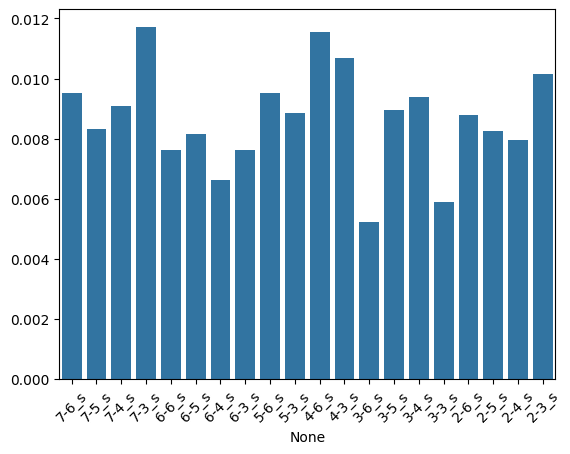

In [242]:
# errors by cells
by_cells = []
for i in y_val.columns:
    mae = mean_absolute_error(
        y_val[i], res_stck_straight_bag[i]    
    )
    by_cells.append(mae)

#average interval of prediction
str_stck_bag_intervals = ( ( ( ((res_stck_straight_bag.to_numpy() - y_val)**2).sum() / ( len(y_val) - 2) )**(1/2) )  * 1.96 ).to_numpy()
print(str_stck_bag_intervals, str_stck_bag_intervals.mean())

sns.barplot(x=res_stck_straight_bag.columns, y=by_cells)
plt.xticks(rotation=45)

<Axes: xlabel='1', ylabel='0'>

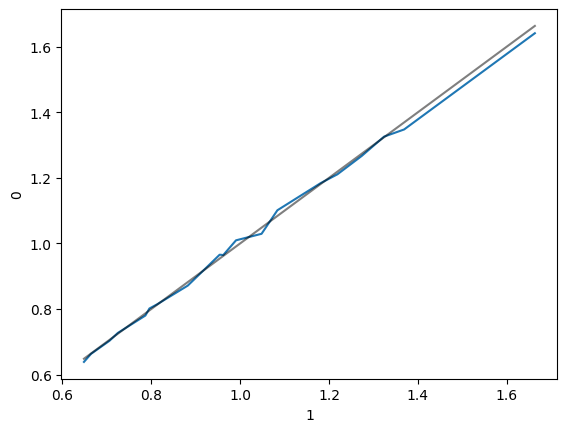

In [243]:
#average interval of prediction

fig, ax = plt.subplots()

str_stck_bag_lower = res_stck_straight_bag - str_stck_bag_intervals
str_stck_bag_upper = res_stck_straight_bag + str_stck_bag_intervals

sns.lineplot(x=y_val.iloc[0], y=res_stck_straight_bag.iloc[0], ax=ax)
sns.lineplot(x=y_val.iloc[0], y=y_val.iloc[0], ax=ax, color="black", alpha=0.5)

# ax.fill_between(y_test_mo["7-6_s"], rch_mo_int_lower, rch_mo_int_upper, alpha=0.2)


In [244]:
d.display(res_stck_straight_bag.iloc[0], dt="_s")

,6,5,4,3
7,0.638933,0.663646,1.101333,0.965853
6,0.801811,1.009653,1.325797,1.266999
5,0.780347,nan,nan,1.347691
4,0.903868,nan,nan,1.641059
3,0.814734,1.184037,1.029567,1.210896
2,0.727250,0.964790,0.703401,0.871495


In [245]:
d.display(y_val.iloc[0], dt="_s")

,6,5,4,3
7,0.648665,0.664725,1.083983,0.954085
6,0.795975,0.990852,1.324040,1.273806
5,0.786919,nan,nan,1.369198
4,0.906925,nan,nan,1.663363
3,0.813529,1.181239,1.048351,1.218998
2,0.724846,0.962203,0.706128,0.882171


In [246]:
from joblib import dump
dump(filename="stck_bag_non_unifor_v1.2.joblib", value=models_str_stck_bag)


['stck_bag_non_unifor_v1.2.joblib']

In [74]:
from main.permutations import Permutations

In [75]:
pind = 104
p = Permutations(df=df.loc[:,
    [
        "Name",
        *d.CORE_PARTS["burnup"]["ALL_CELLS"],
        *d.CORE_PARTS["fuel_type"]["ALL_CELLS"],
        *fuel_left_cols
    ]
], ind=pind)

In [76]:
p.df

,Name,7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,6-4_b,6-3_b,5-6_b,...,4-6_l,4-3_l,3-6_l,3-5_l,3-4_l,3-3_l,2-6_l,2-5_l,2-4_l,2-3_l
104,120_fake_burn3_e1,29.52,140.76,140.55,172.26,99.799,16.5625,161.438,51.4365,105.629,...,235.108,205.02,165.2275,115.858,247.3245,215.3655,150.81,131.04,241.53,237.18


In [77]:
d.display(p.df.loc[pind, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy(), dt="burnup")

,6,5,4,3
7,29.520000,140.760000,140.550000,172.260000
6,99.799000,16.562500,161.438000,51.436500
5,105.629000,nan,nan,94.860000
4,29.892000,nan,nan,94.980000
3,99.772500,149.142000,17.675500,49.634500
2,149.190000,168.960000,58.470000,62.820000


In [78]:
d.display(p.df.loc[pind, d.CORE_PARTS["left"]["ALL_CELLS"]].to_numpy(), dt="burnup")

,6,5,4,3
7,270.480000,159.240000,159.450000,127.740000
6,165.201000,248.437500,103.562000,213.563500
5,159.371000,nan,nan,205.140000
4,235.108000,nan,nan,205.020000
3,165.227500,115.858000,247.324500,215.365500
2,150.810000,131.040000,241.530000,237.180000


In [79]:
df_perm = p.make_permutations(cells_from=["2-6", "7-4", "7-3", "7-6"], cells_to=["2-4", "2-5", "4-3", "5-3"])

Detected among six tubes [] Detected among eight tubes ['2-6', '7-3', '5-3', '2-5', '7-6', '7-4', '4-3', '2-4']


In [80]:
df_perm = df_perm.loc[:, [*d.CORE_PARTS["burnup"]["ALL_CELLS"], *fuel_left_cols]]
df_perm

,7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,6-4_b,6-3_b,5-6_b,5-3_b,...,4-6_l,4-3_l,3-6_l,3-5_l,3-4_l,3-3_l,2-6_l,2-5_l,2-4_l,2-3_l
104,94.86,140.76,168.96,94.98,99.799,16.5625,161.438,51.4365,105.629,29.52,...,235.108,127.74,165.2275,115.858,247.3245,215.3655,241.53,159.45,150.81,237.18


In [84]:
perm_pred = validation_stacking_bagging(models_str_stck_bag, df_perm)
perm_pred

,7-6_s,7-5_s,7-4_s,7-3_s,6-6_s,6-5_s,6-4_s,6-3_s,5-6_s,5-3_s,4-6_s,4-3_s,3-6_s,3-5_s,3-4_s,3-3_s,2-6_s,2-5_s,2-4_s,2-3_s
0,0.877624,0.76204,0.707536,0.999006,0.828236,1.3153,0.799129,1.224783,0.933122,1.551263,1.160983,0.959177,0.845669,0.827535,1.35103,1.188195,0.953896,0.795123,0.768431,1.091424


In [82]:
d.display(df.loc[pind, d.CORE_PARTS["coef"]["ALL_CELLS"]].to_numpy(), dt="burnup")


,6,5,4,3
7,0.975777,0.760367,0.828397,0.703382
6,0.843657,1.279728,0.761998,1.223763
5,0.940597,nan,nan,1.295722
4,1.165640,nan,nan,1.318447
3,0.860237,0.807080,1.358968,1.246582
2,0.709241,0.722358,1.070489,1.127570


In [83]:
d.display(perm_pred.iloc[0], dt="_s")


,6,5,4,3
7,0.877624,0.762040,0.707536,0.999006
6,0.828236,1.315300,0.799129,1.224783
5,0.933122,nan,nan,1.551263
4,1.160983,nan,nan,0.959177
3,0.845669,0.827535,1.351030,1.188195
2,0.953896,0.795123,0.768431,1.091424


In [76]:
df_burnup_only = pd.read_excel("input_burnup.xlsx", sheet_name="default_burnup_only")

<Axes: ylabel='3-6_s'>

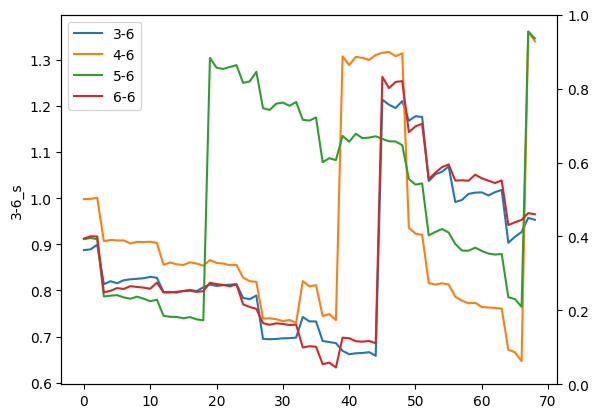

In [77]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
sns.lineplot(df_burnup_only["3-6_s"], ax=ax, label="3-6")
sns.lineplot(df_burnup_only["4-6_s"], ax=ax, label="4-6")
# sns.lineplot(df_burnup_only["4-6_b"], ax=ax2, color="black")
sns.lineplot(df_burnup_only["5-6_s"], ax=ax, label="5-6")
sns.lineplot(df_burnup_only["6-6_s"], ax=ax, label="6-6")
# sns.lineplot(df_burnup_only["5-6_b"], ax=ax2, color="grey")


# Simulation of burnup with fuel consumption

In [2650]:
from main.burnup import Burnup

In [2651]:
df_burnup = pd.read_excel("input_burnup.xlsx")

In [2652]:
d.display(df_burnup.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,16.140000,57.120000,25.920000,150.180000
6,0.000000,76.000000,141.030000,157.360000
5,83.160000,nan,nan,116.160000
4,18.270000,nan,nan,115.410000
3,0.000000,129.060000,74.840000,149.960000
2,130.200000,32.430000,55.380000,146.820000


In [2653]:
percentage_cols =  d.CORE_PARTS["percentage"]["ALL_CELLS"]

df_burnup.loc[:, percentage_cols] = df_burnup.loc[:, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() / df_burnup.loc[:, d.CORE_PARTS["fuel_type"]["ALL_CELLS"]].to_numpy() * 100

In [2654]:
fuel_left_cols = d.CORE_PARTS["left"]["ALL_CELLS"]

df_burnup.loc[:, fuel_left_cols] = df_burnup.loc[:, d.CORE_PARTS["fuel_type"]["ALL_CELLS"]].to_numpy() - df_burnup.loc[:, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()

In [2655]:
U_per_step = 18.423

In [2656]:
loss_by_step = np.full((20,), 0.0)
for i in range(1, len(df_burnup)):
    
    loss = df_burnup.loc[i, d.CORE_PARTS["coef"]["ALL_CELLS"]].to_numpy()\
    * (df_burnup.loc[i, "loss_grams_per_step"] - U_per_step) / 20

    df_burnup.loc[i, d.CORE_PARTS["burnup"]["ALL_CELLS"]] = df_burnup.loc[i, d.CORE_PARTS["burnup"]["ALL_CELLS"]] - loss - loss_by_step
        
    loss_by_step = np.add(loss_by_step, loss)
# loss_by_step.append(loss)
    

In [2657]:
(df_burnup.loc[4, d.CORE_PARTS["burnup"]["ALL_CELLS"]] - df_burnup.loc[3, d.CORE_PARTS["burnup"]["ALL_CELLS"]]).sum()

18.413008349999924

In [2658]:
d.display(df_burnup.loc[0, d.CORE_PARTS["coef"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,1.118000,1.052000,1.108000,0.752000
6,1.267000,1.158000,0.875000,0.725000
5,1.125000,nan,nan,1.079000
4,1.323000,nan,nan,1.040000
3,1.221000,0.872000,1.077000,0.705000
2,0.788000,1.053000,0.948000,0.715000


In [2659]:
d.display(df_burnup.loc[0, d.CORE_PARTS["percentage"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,5.380000,19.040000,8.640000,50.060000
6,0.000000,28.679245,53.218868,59.381132
5,31.381132,nan,nan,38.720000
4,6.090000,nan,nan,38.470000
3,0.000000,48.701887,28.241509,56.588679
2,43.400000,10.810000,18.460000,48.940000


In [653]:
df_zero_step_raw = df_burnup.loc[:, [
        *d.CORE_PARTS["burnup"]["ALL_CELLS"], 
        *d.CORE_PARTS["left"]["ALL_CELLS"],
        *d.CORE_PARTS["fuel_type"]["ALL_CELLS"],
    ]
]

In [2664]:
df_zero_step = ct_mo.transform(df_zero_step_raw)
sim_zero_step = validation_stacking_bagging(models_str_stck_bag, df_zero_step_raw)

In [2665]:
sim_zero_step

,7-6_s,7-5_s,7-4_s,7-3_s,6-6_s,6-5_s,6-4_s,6-3_s,5-6_s,5-3_s,4-6_s,4-3_s,3-6_s,3-5_s,3-4_s,3-3_s,2-6_s,2-5_s,2-4_s,2-3_s
0,1.134984,1.061768,1.128299,0.754300,1.261375,1.163548,0.872343,0.716633,1.132321,1.076818,1.317372,1.031610,1.206563,0.872368,1.072447,0.693264,0.790102,1.050542,0.944420,0.709112
1,1.135445,1.062222,1.133559,0.751811,1.260895,1.162373,0.872834,0.717193,1.131284,1.081613,1.317686,1.037887,1.206086,0.874668,1.077797,0.694382,0.791464,1.057405,0.947134,0.709791
2,1.135807,1.058311,1.134042,0.752501,1.260456,1.162729,0.873485,0.716929,1.130841,1.081483,1.317798,1.038221,1.205445,0.875451,1.078036,0.694632,0.792145,1.057985,0.947906,0.710195
3,1.135049,1.058819,1.140969,0.755386,1.259149,1.164378,0.873951,0.717902,1.126751,1.082005,1.317206,1.038396,1.204919,0.875849,1.079428,0.695628,0.786162,1.057698,0.948668,0.710655
4,1.132033,1.057466,1.126382,0.749950,1.254827,1.160918,0.868148,0.713543,1.124609,1.091607,1.318860,1.038219,1.204941,0.874151,1.077772,0.698027,0.789858,1.062459,0.954591,0.718483
5,1.132140,1.058261,1.128014,0.750609,1.254517,1.161034,0.868942,0.713525,1.124127,1.071834,1.319127,1.037663,1.205168,0.874605,1.078168,0.698346,0.792528,1.063238,0.955508,0.718700
6,1.133005,1.063444,1.130464,0.755757,1.253760,1.161552,0.869867,0.715143,1.123885,1.072678,1.322319,1.036805,1.204673,0.868815,1.078532,0.699318,0.792762,1.063617,0.956123,0.719053
7,1.133316,1.064636,1.131125,0.758470,1.253320,1.162332,0.870362,0.715161,1.126241,1.069378,1.331738,1.037080,1.204727,0.869761,1.078911,0.700091,0.786955,1.064105,0.957072,0.719565
8,1.134463,1.066185,1.132816,0.759796,1.250530,1.164572,0.870686,0.715734,1.123181,1.073993,1.332101,1.040761,1.203343,0.869690,1.079375,0.706656,0.770566,1.064227,0.958456,0.719853


In [2667]:
d.display(sim_zero_step.iloc[0], dt="_s")


,6,5,4,3
7,1.134984,1.061768,1.128299,0.754300
6,1.261375,1.163548,0.872343,0.716633
5,1.132321,nan,nan,1.076818
4,1.317372,nan,nan,1.031610
3,1.206563,0.872368,1.072447,0.693264
2,0.790102,1.050542,0.944420,0.709112


In [2668]:
df_zero_step_raw.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]] = sim_zero_step

## 1st step of burnup simulation

In [2672]:
b1 = Burnup(df_zero_step_raw)
df_burnt_raw1 = b1.simulate_burnup("2.0833d", 0)

In [2674]:

sim_step1 = validation_stacking_bagging(models_str_stck_bag, df_burnt_raw1)

In [2675]:
d.display(df_burnup.loc[1, d.CORE_PARTS["coef"]["ALL_CELLS"]].to_numpy(), dt="_s")

,6,5,4,3
7,1.107000,1.046000,1.103000,0.756000
6,1.243000,1.154000,0.876000,0.733000
5,1.122000,nan,nan,1.088000
4,1.316000,nan,nan,1.056000
3,1.207000,0.874000,1.082000,0.715000
2,0.788000,1.053000,0.953000,0.727000


In [2676]:
d.display(sim_step1.iloc[0], dt="_s")


,6,5,4,3
7,1.135492,1.062297,1.133636,0.752348
6,1.260797,1.162269,0.872739,0.717065
5,1.131092,nan,nan,1.081728
4,1.317295,nan,nan,1.038008
3,1.206045,0.874535,1.077712,0.694341
2,0.790918,1.057046,0.947230,0.709964


In [2677]:
d.display(df_burnup.loc[1, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,17.274078,58.164404,27.024099,150.865955
6,1.103350,77.003826,141.775313,157.966078
5,84.103997,nan,nan,117.204179
4,19.582959,nan,nan,116.424350
3,1.083543,129.795324,75.754211,150.546175
2,130.945784,33.474366,56.304901,147.476111


In [2678]:
d.display(df_burnt_raw1.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,17.185552,58.098105,26.959394,150.874865
6,1.161984,77.071865,141.833606,158.020165
5,84.203098,nan,nan,117.151969
4,19.483568,nan,nan,116.360323
3,1.111491,129.863629,75.827942,150.598638
2,130.927845,33.397764,56.250004,147.473237


In [2679]:
burnup_mcu1 = (df_burnup.loc[1, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnup.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum()
burnup_sim1 = (df_burnt_raw1.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_zero_step_raw.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum()

print(
    "sum burnup on 1st step from MCU: ", burnup_mcu1
)
print(
    "sum burnup on 1st step: ", burnup_sim1
)
print(
    "total loss on prediction of 1st step:", (df_burnt_raw1.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnup.loc[1, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum() #+ burnup_mcu1 - burnup_sim1
)

print("error on cells: ", mean_absolute_error(
    df_burnt_raw1.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy(), 
    df_burnup.loc[1, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()
))

sum burnup on 1st step from MCU:  18.433005350000037
sum burnup on 1st step:  18.415043945899654
total loss on prediction of 1st step: -0.017961404100381495
error on cells:  0.05784900297435493


In [2680]:
df_burnt_raw1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]] = sim_step1

In [2681]:
df_burnt_raw1

,7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,6-4_b,6-3_b,5-6_b,5-3_b,...,4-6_s,4-3_s,3-6_s,3-5_s,3-4_s,3-3_s,2-6_s,2-5_s,2-4_s,2-3_s
0,17.185552,58.098105,26.959394,150.874865,1.161984,77.071865,141.833606,158.020165,84.203098,117.151969,...,1.317295,1.038008,1.206045,0.874535,1.077712,0.694341,0.790918,1.057046,0.94723,0.709964


## 2nd step of burnup simulation

In [2683]:
b2 = Burnup(df_burnt_raw1)
df_burnt_raw2 = b2.simulate_burnup("2.0833d", 0)

In [2685]:

sim_step2 = validation_stacking_bagging(models_str_stck_bag, df_burnt_raw2)

In [2686]:
d.display(df_burnup.loc[2, d.CORE_PARTS["coef"]["ALL_CELLS"]].to_numpy(), dt="_s")

,6,5,4,3
7,1.112000,1.051000,1.109000,0.760000
6,1.245000,1.155000,0.878000,0.735000
5,1.121000,nan,nan,1.085000
4,1.314000,nan,nan,1.052000
3,1.204000,0.873000,1.080000,0.712000
2,0.787000,1.051000,0.952000,0.723000


In [2688]:
d.display(sim_step2.iloc[0], dt="_s")

,6,5,4,3
7,1.135819,1.058357,1.134054,0.752523
6,1.260270,1.162455,0.873242,0.716731
5,1.130467,nan,nan,1.081699
4,1.317821,nan,nan,1.038479
3,1.205329,0.875225,1.077964,0.694571
2,0.792277,1.058126,0.948202,0.710387


In [2689]:
d.display(df_burnup.loc[2, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,18.343291,59.174209,28.093342,151.608583
6,2.211273,78.002623,142.506797,158.568949
5,85.073124,nan,nan,118.243655
4,20.860214,nan,nan,117.434146
3,2.131864,130.526856,76.703735,151.149268
2,131.718150,34.514172,57.255667,148.189097


In [2690]:
d.display(df_burnt_raw2.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,18.231572,59.076697,28.003704,151.567931
6,2.323435,78.142551,142.637577,158.680728
5,85.245064,nan,nan,118.148462
4,20.697066,nan,nan,117.316541
3,2.222504,130.669254,76.820734,151.238268
2,131.656442,34.371518,57.122596,148.127258


In [2691]:
burnup_mcu2 = (df_burnup.loc[2, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnup.loc[1, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum()
burnup_sim2 = (df_burnt_raw2.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnt_raw1.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum()

print(
    "sum burnup on 2nd step from MCU: ", burnup_mcu2
)
print(
    "sum burnup on 2nd step: ", burnup_sim2
)
print(
    "total loss on prediction of 2st step:", (df_burnt_raw2.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnup.loc[2, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum() #+ burnup_mcu1 - burnup_sim1 + burnup_mcu2 - burnup_sim1
)




sum burnup on 2nd step from MCU:  18.4360097
sum burnup on 2nd step:  18.444858768957545
total loss on prediction of 2st step: -0.009112335142838823


In [2692]:
df_burnt_raw2.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]] = sim_step2

In [2693]:
df_burnt_raw2

,7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,6-4_b,6-3_b,5-6_b,5-3_b,...,4-6_s,4-3_s,3-6_s,3-5_s,3-4_s,3-3_s,2-6_s,2-5_s,2-4_s,2-3_s
0,18.231572,59.076697,28.003704,151.567931,2.323435,78.142551,142.637577,158.680728,85.245064,118.148462,...,1.317821,1.038479,1.205329,0.875225,1.077964,0.694571,0.792277,1.058126,0.948202,0.710387


In [676]:
1.498E4/1000*24

359.52

## 3d step of burnup simulation

In [677]:
b3 = Burnup(df_burnt_raw2)
df_burnt_raw3 = b3.simulate_burnup("2.0833d", 0)

In [678]:
df_burnt = ct_mo.transform(df_burnt_raw3)
sim_step3 = rch_ridge.predict(df_burnt)

In [679]:
d.display(df_burnup.loc[3, d.CORE_PARTS["coef"]["ALL_CELLS"]].to_numpy(), dt="_s")

,6,5,4,3
7,1.117000,1.051000,1.110000,0.757000
6,1.246000,1.157000,0.878000,0.732000
5,1.122000,nan,nan,1.085000
4,1.314000,nan,nan,1.051000
3,1.204000,0.870000,1.082000,0.712000
2,0.786000,1.048000,0.953000,0.725000


In [680]:
d.display(sim_step3[0], dt="_s")

,6,5,4,3
7,1.124537,1.066551,1.125371,0.754706
6,1.250313,1.161722,0.872307,0.723453
5,1.123669,nan,nan,1.072550
4,1.313953,nan,nan,1.030997
3,1.211431,0.872066,1.072202,0.698377
2,0.792978,1.061946,0.952674,0.718200


In [681]:
d.display(df_burnup.loc[3, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,19.447315,60.218586,29.197403,152.324533
6,3.284607,78.976433,143.272099,159.195033
5,86.027121,nan,nan,119.287850
4,22.173184,nan,nan,118.418523
3,3.185422,131.262202,77.627947,151.755459
2,132.463945,35.558565,58.180568,148.875219


In [682]:
d.display(df_burnt_raw3.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy())

,6,5,4,3
7,19.250244,60.066346,29.028063,152.262914
6,3.463390,79.216779,143.440796,159.354911
5,86.274071,nan,nan,119.123635
4,21.908168,nan,nan,118.258423
3,3.353583,131.467008,77.804787,151.882722
2,132.389431,35.361639,58.006465,148.798867


In [683]:
burnup_mcu3 = (df_burnup.loc[3, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnup.loc[2, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum()
burnup_sim3 = (df_burnt_raw3.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnt_raw2.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum()

print(
    "sum burnup on 3d step from MCU: ", burnup_mcu3
)
print(
    "sum burnup on 3d step: ", burnup_sim3
)
print(
    "total loss on prediction of 3d step:", (df_burnt_raw3.loc[0, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() - df_burnup.loc[3, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()).sum() #+ burnup_mcu1 - burnup_sim1 + burnup_mcu2 - burnup_sim1
)

sum burnup on 3d step from MCU:  18.422999999999977
sum burnup on 3d step:  18.424080209999993
total loss on prediction of 3d step: -0.019774420000066684


In [684]:
df_burnt_raw3.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]] = sim_step3

In [685]:
df_burnt_raw3

,7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,6-4_b,6-3_b,5-6_b,5-3_b,...,4-6_s,4-3_s,3-6_s,3-5_s,3-4_s,3-3_s,2-6_s,2-5_s,2-4_s,2-3_s
0,19.250244,60.066346,29.028063,152.262914,3.46339,79.216779,143.440796,159.354911,86.274071,119.123635,...,1.313953,1.030997,1.211431,0.872066,1.072202,0.698377,0.792978,1.061946,0.952674,0.7182
